<a href="https://colab.research.google.com/github/hiseulgi/alpaca-classifier-efficientnetv2b3/blob/main/transfer_learning_alpaca_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Preparation

### Downloading Datasets

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download sid4sal/alpaca-dataset-small

alpaca-dataset-small.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip alpaca-dataset-small.zip

Archive:  alpaca-dataset-small.zip
replace dataset/alpaca/01ad3ff1d94eb557.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/alpaca/0346463867a297f4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/alpaca/0346463867a297f4.jpg  
  inflating: dataset/alpaca/038fae9e70c4c3f1.jpg  
  inflating: dataset/alpaca/053608552d63f724.jpg  
  inflating: dataset/alpaca/053dab62fbb47736.jpg  
  inflating: dataset/alpaca/063a50c0a6408396.jpg  
  inflating: dataset/alpaca/098cc30753a9cf13.jpg  
  inflating: dataset/alpaca/09915aad4cd6bf0d.jpg  
  inflating: dataset/alpaca/09e382a83978039b.jpg  
  inflating: dataset/alpaca/0a2ea8f93b4cb30a.jpg  
  inflating: dataset/alpaca/0b2a2c061ef16759.jpg  
  inflating: dataset/alpaca/0cb5cae66bb9c4cd.jpg  
  inflating: dataset/alpaca/0dba33ff827acee8.jpg  
  inflating: dataset/alpaca/0e6044cdcd9318f3.jpg  
  inflating: dataset/alpaca/0e6ba4d54d478f76.jpg  
  inflating: dataset/alpaca/10371d58e9cf119d.jpg  
  inflating: dataset/alpaca/10

### Import Datasets

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [ ]:
data_dir = pathlib.Path('/content/dataset')

# Total Image on Datasets
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

327

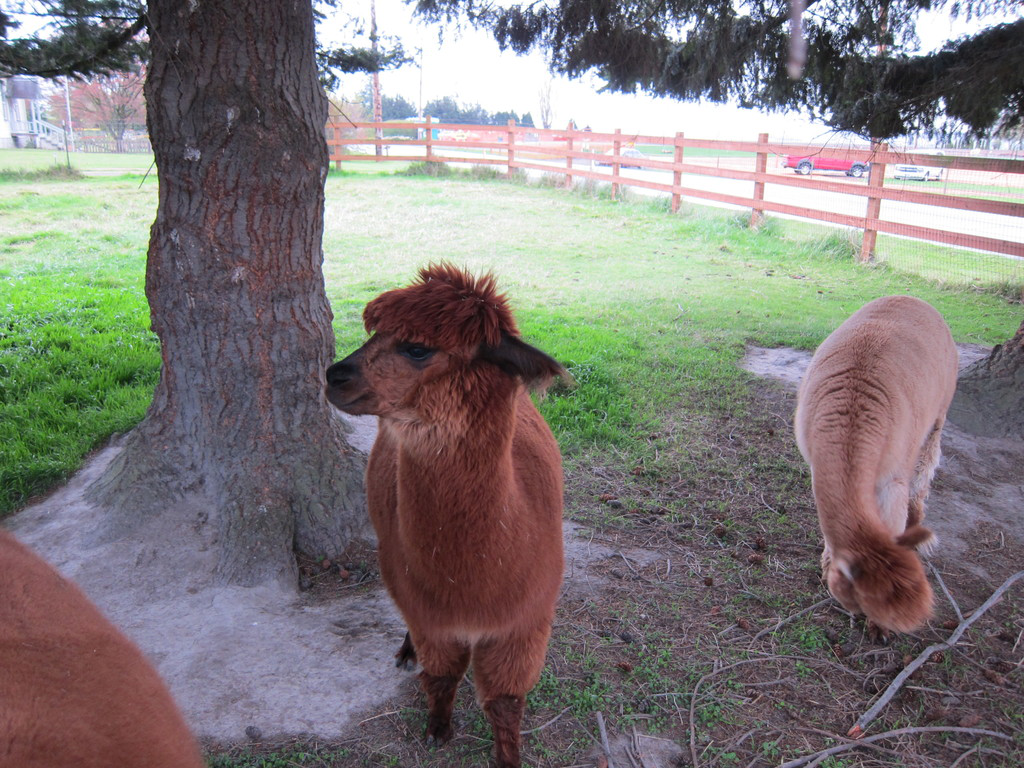

In [ ]:
alpacas = list(data_dir.glob('alpaca/*'))
PIL.Image.open(str(alpacas[1]))

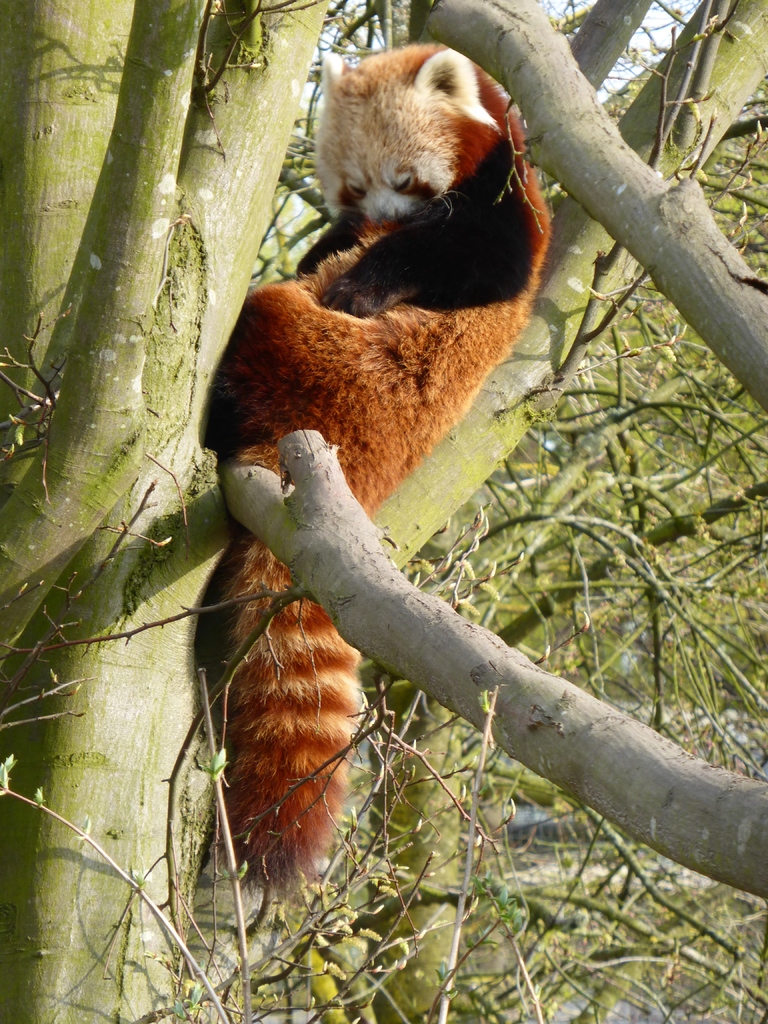

In [ ]:
not_alpacas = list(data_dir.glob('not alpaca/*'))
PIL.Image.open(str(not_alpacas[44]))

### Create Dataset

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

Found 327 files belonging to 2 classes.
Using 262 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [ ]:
# See class names in datasets
class_names = train_ds.class_names
class_names

['alpaca', 'not alpaca']

### Visualize the Data

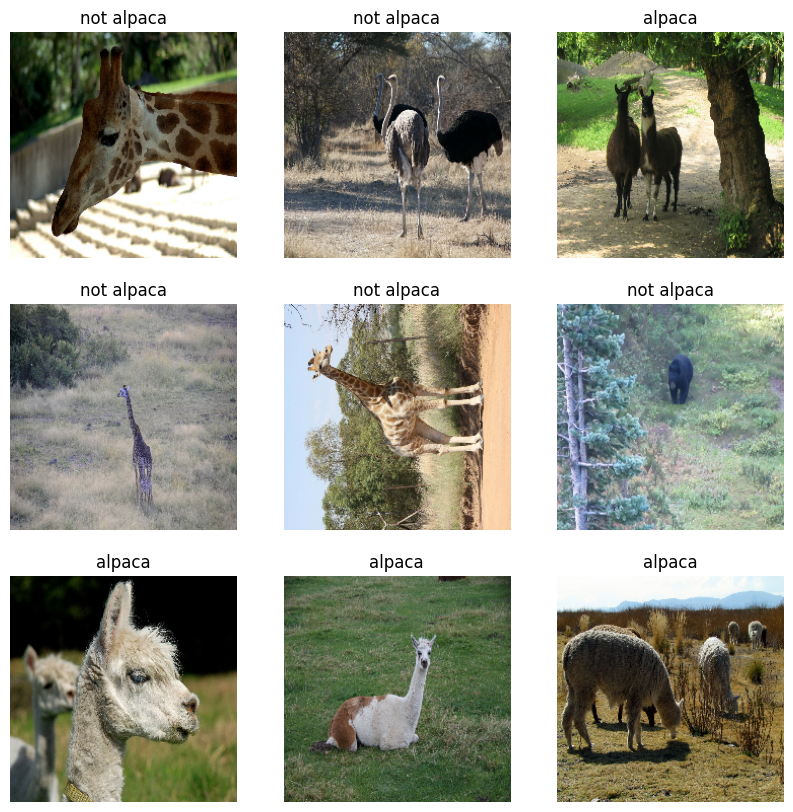

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# See information batches of images from dataset
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Modelling Part 1

### Standarization

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configure for Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Build the Model

In [ ]:
NUM_CLASSES = 2

# model = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255),

#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Conv2D(128, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES)
# ])

In [ ]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

In [ ]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10
# )

# OUTPUT
# Epoch 1/10
# 9/9 [==============================] - 45s 5s/step - loss: 1.4440 - accuracy: 0.5649 - val_loss: 0.6932 - val_accuracy: 0.5692
# Epoch 2/10
# 9/9 [==============================] - 41s 5s/step - loss: 0.6851 - accuracy: 0.5496 - val_loss: 0.6983 - val_accuracy: 0.4923
# Epoch 3/10
# 9/9 [==============================] - 41s 5s/step - loss: 0.6843 - accuracy: 0.5916 - val_loss: 0.6915 - val_accuracy: 0.5231
# Epoch 4/10
# 9/9 [==============================] - 39s 4s/step - loss: 0.6682 - accuracy: 0.5840 - val_loss: 0.6779 - val_accuracy: 0.5231
# Epoch 5/10
# 9/9 [==============================] - 44s 5s/step - loss: 0.6337 - accuracy: 0.6260 - val_loss: 0.6621 - val_accuracy: 0.6462
# Epoch 6/10
# 9/9 [==============================] - 40s 5s/step - loss: 0.6115 - accuracy: 0.6641 - val_loss: 0.6374 - val_accuracy: 0.6154
# Epoch 7/10
# 9/9 [==============================] - 42s 5s/step - loss: 0.6054 - accuracy: 0.6603 - val_loss: 0.6444 - val_accuracy: 0.5231
# Epoch 8/10
# 9/9 [==============================] - 39s 4s/step - loss: 0.5676 - accuracy: 0.6489 - val_loss: 0.6194 - val_accuracy: 0.5846
# Epoch 9/10
# 9/9 [==============================] - 40s 4s/step - loss: 0.5159 - accuracy: 0.7214 - val_loss: 0.6157 - val_accuracy: 0.6154
# Epoch 10/10
# 9/9 [==============================] - 41s 4s/step - loss: 0.4998 - accuracy: 0.6985 - val_loss: 0.6346 - val_accuracy: 0.6462


NameError: ignored

In [ ]:
# model.summary()

## Modelling Part 2 (Data Augmentation)

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    # tf.keras.layers.RandomTranslation(0.2, 0.2),
    # tf.keras.layers.RandomBrightness(factor=0.2),
    # tf.keras.layers.RandomContrast(factor=0.2),

])

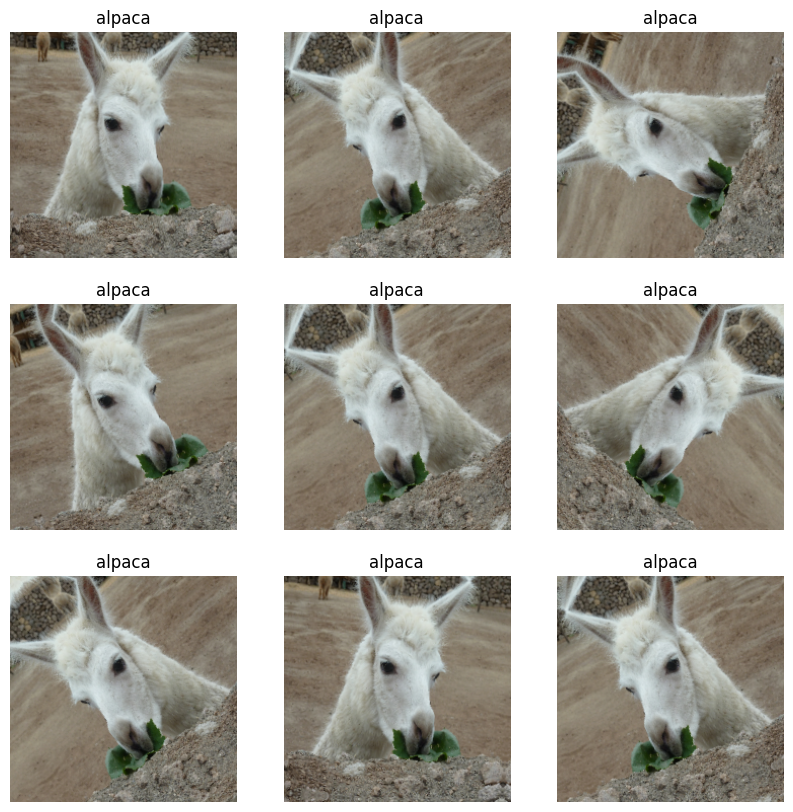

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    aug_img = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")

### Build the Model

In [ ]:
NUM_CLASSES = 2

# model_aug = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255),
#     data_augmentation,

#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Conv2D(128, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES)
# ])

In [ ]:
# model_aug.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

In [ ]:
# history_aug = model_aug.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10
# )

# OUTPUT
# Epoch 1/10
# 9/9 [==============================] - 47s 5s/step - loss: 114.0593 - accuracy: 0.5458 - val_loss: 0.6930 - val_accuracy: 0.4923
# Epoch 2/10
# 9/9 [==============================] - 43s 5s/step - loss: 0.7770 - accuracy: 0.5878 - val_loss: 0.6932 - val_accuracy: 0.4923
# Epoch 3/10
# 9/9 [==============================] - 43s 5s/step - loss: 0.6915 - accuracy: 0.5725 - val_loss: 0.6934 - val_accuracy: 0.4923
# Epoch 4/10
# 9/9 [==============================] - 43s 5s/step - loss: 0.6850 - accuracy: 0.5916 - val_loss: 0.6932 - val_accuracy: 0.4923
# Epoch 5/10
# 9/9 [==============================] - 43s 5s/step - loss: 0.6944 - accuracy: 0.5802 - val_loss: 0.6934 - val_accuracy: 0.4923
# Epoch 6/10
# 9/9 [==============================] - 46s 5s/step - loss: 0.6852 - accuracy: 0.5840 - val_loss: 0.6943 - val_accuracy: 0.4923
# Epoch 7/10
# 9/9 [==============================] - 43s 5s/step - loss: 0.6868 - accuracy: 0.5840 - val_loss: 0.6954 - val_accuracy: 0.4923
# Epoch 8/10
# 9/9 [==============================] - 43s 5s/step - loss: 0.6841 - accuracy: 0.5840 - val_loss: 0.6968 - val_accuracy: 0.4923
# Epoch 9/10
# 9/9 [==============================] - 44s 5s/step - loss: 0.6800 - accuracy: 0.5840 - val_loss: 0.6980 - val_accuracy: 0.4923
# Epoch 10/10
# 9/9 [==============================] - 45s 5s/step - loss: 0.6836 - accuracy: 0.5840 - val_loss: 0.6991 - val_accuracy: 0.4923

In [ ]:
# # Path file gambar
# image_path = '/content/dataset/alpaca/4a93aa9f00ea6c70.jpg'

# # Membaca gambar menggunakan PIL
# pred_image = PIL.Image.open(image_path)

# # Menampilkan gambar menggunakan plt
# plt.imshow(pred_image)
# plt.axis('off')  # Menghilangkan sumbu x dan y pada plot
# plt.show()

# pred_image = pred_image.resize((224, 224))  # Resize the image to match the input size of the model
# pred_image = np.array(pred_image)  # Convert the image to numpy array
# pred_image = pred_image / 255.0  # Normalize the pixel values

# # Reshape the image to match the input shape expected by the model
# pred_image = np.expand_dims(pred_image, axis=0)

# # Make predictions
# predictions = model_aug.predict(pred_image)

# # Convert probabilities to class labels
# predicted_class = np.argmax(predictions[0])
# predicted_label = class_names[predicted_class]

# print("Predicted label:", predicted_label)

Masih jelek wkwkwkwk

### Kesimpulan Sementara
- Model 1 (Tanpa Augmentasi): Performa (Loss, Accuracy) model kurang stabil ketika proses training
- Model 2 (Dengan Augmentasi): Performa model semakin lama iterasi semakin meningkat, hingga stagnan.
- Maka, kemungkinan masalahnya ada di **Arsitektur Modelnya** atau dari **Datanya sendiri**. Maka dari itu, kita akan mencobanya dengan **Transfer Learning**.

## Modelling Part 3 (EfficientNetB3 (300x300) Transfer Learning)

Kita mulai dari import dataset lagi dariawal. Karena membingungkan kalau pake preparation untuk model CNN Scratch.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

### Setup and data loading

In [8]:
data_dir = pathlib.Path('/content/dataset')

# Total Image on Datasets
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

327

In [9]:
BATCH_SIZE = 32
IMG_SIZE = 300
NUM_CLASSES = 2

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

Found 327 files belonging to 2 classes.
Using 262 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [12]:
# See class names in datasets
class_names = train_ds.class_names
class_names

['alpaca', 'not alpaca']

### Data augmentation

In [13]:
img_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(factor=0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip('horizontal')
    ])

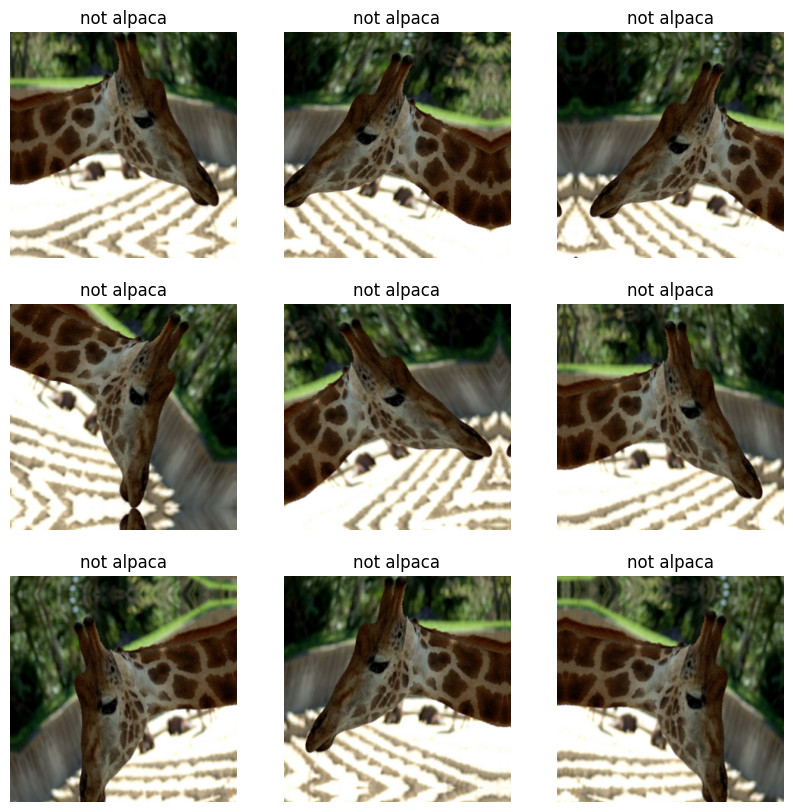

In [14]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    aug_img = img_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")

### Prepare inputs

In [15]:
# Categorical encoding
def input_preprocess(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

train_ds = train_ds.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
# train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(input_preprocess)
# val_ds = val_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

### Model building

In [62]:
NUM_CLASSES = 2

# Input Layers and Base Model EfficientNetV2B3 (300x300)
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
base_model = tf.keras.applications.EfficientNetV2B3(
    include_top=False,
    weights='imagenet',
    input_tensor=x
)

# Freeze pretrained weights
base_model.trainable = False

# Rebuild Top Layers
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Dense Layer for Classification
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(
    NUM_CLASSES,
    activation='softmax'
)(x)

# Compile model
model_effnetv2b3 = tf.keras.Model(inputs, outputs, name='efficientNet')

model_effnetv2b3.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# model_eff_scratch.summary()

In [63]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
]

In [64]:
epochs = 50  # @param {type: "slider", min:10, max:100}

history_effnetv2b3 = model_effnetv2b3.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=my_callbacks,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
9/9 [==============================] - 19s 588ms/step - loss: 0.4708 - accuracy: 0.7863 - val_loss: 0.2975 - val_accuracy: 0.9077 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 4s 323ms/step - loss: 0.0899 - accuracy: 0.9771 - val_loss: 0.2148 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 4s 338ms/step - loss: 0.0528 - accuracy: 0.9809 - val_loss: 0.1768 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 4s 338ms/step - loss: 0.0454 - accuracy: 0.9809 - val_loss: 0.1589 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 5s 294ms/step - loss: 0.0848 - accuracy: 0.9695 - val_loss: 0.1524 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 4s 266ms/step - loss: 0.0701 - accuracy: 0.9809 - val_loss: 0.1367 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 4s 339ms/step - loss: 0.0218 - 

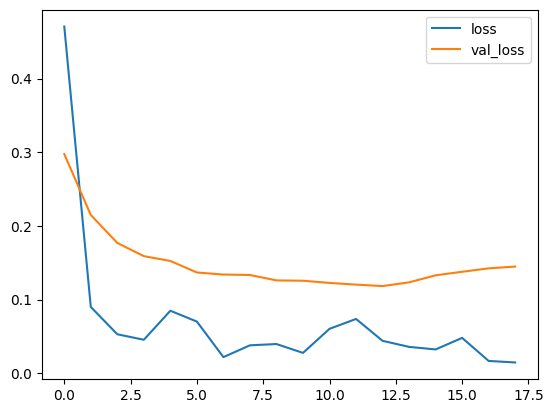

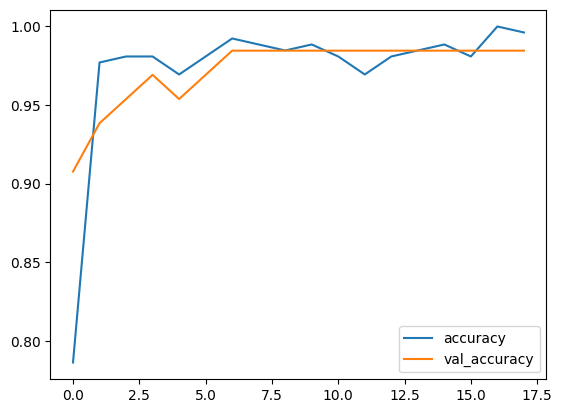

In [65]:
plt.plot(history_effnetv2b3.history['loss'], label='loss')
plt.plot(history_effnetv2b3.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history_effnetv2b3.history['accuracy'], label='accuracy')
plt.plot(history_effnetv2b3.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### Saving model

In [66]:
model_effnetv2b3.save_weights("/content/drive/MyDrive/Learning/Transfer Learning/Alpaca or Not/effnetv2b3-alpaca-weights.h5")

In [67]:
model_effnetv2b3.save("/content/drive/MyDrive/Learning/Transfer Learning/Alpaca or Not/effnev2tb3-alpaca.h5")


### Test saved model

In [68]:
model_import = tf.keras.saving.load_model("/content/drive/MyDrive/Learning/Transfer Learning/Alpaca or Not/effnev2tb3-alpaca.h5")

In [ ]:
# model_import.summary()

In [92]:
import requests 

def test_predict(model, image_url):
  response = requests.get(image_url)
  response.raise_for_status()  # Periksa apakah permintaan unduhan berhasil

  # Simpan gambar ke file
  image_path = '/content/test_image.jpg'  # Ganti dengan path dan nama file tujuan
  with open(image_path, 'wb') as file:
      file.write(response.content)

  # Membaca gambar menggunakan PIL
  pred_image = PIL.Image.open(image_path)

  # Menampilkan gambar menggunakan plt
  plt.imshow(pred_image)
  plt.axis('off')  # Menghilangkan sumbu x dan y pada plot
  plt.show()

  # Image Preprocessing
  pred_image = pred_image.resize((300, 300))  # Resize the image to match the input size of the model
  pred_image = np.array(pred_image)  # Convert the image to numpy array

  # Reshape the image to match the input shape expected by the model
  pred_image = np.expand_dims(pred_image, axis=0)

  # Make predictions
  predictions = model.predict(pred_image)
  print(predictions)
  print(f"Alpaca Rate: {predictions[0][0]:.4f}")
  print(f"Not Alpaca Rate: {predictions[0][1]:.4f}")

  # Convert probabilities to class labels
  predicted_class = np.argmax(predictions[0])
  class_labels = ['Alpaca', 'Not Alpaca']  # Replace with your own class labels
  predicted_label = class_labels[predicted_class]

  print("Predicted label:", predicted_label)
  

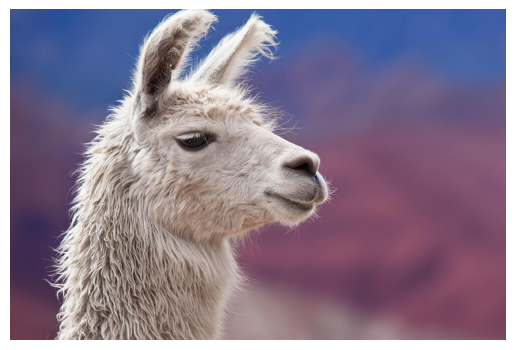

1/1 [==============================] - 0s 202ms/step
[[9.9995089e-01 4.9130176e-05]]
Alpaca Rate: 1.0000
Not Alpaca Rate: 0.0000
Predicted label: Alpaca


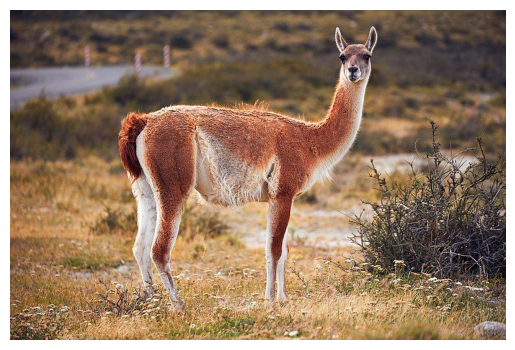

1/1 [==============================] - 0s 113ms/step
[[9.999387e-01 6.121427e-05]]
Alpaca Rate: 0.9999
Not Alpaca Rate: 0.0001
Predicted label: Alpaca


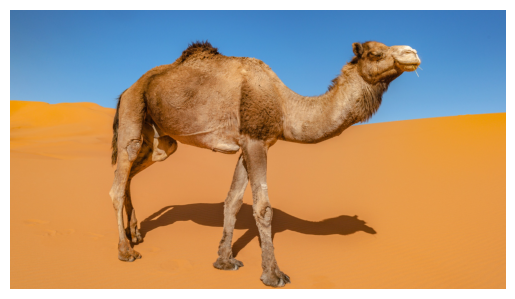

1/1 [==============================] - 0s 33ms/step
[[1.2968162e-05 9.9998701e-01]]
Alpaca Rate: 0.0000
Not Alpaca Rate: 1.0000
Predicted label: Not Alpaca


In [97]:
# ALPACA TEST
# test_predict(model_import, "https://cdn1-production-images-kly.akamaized.net/ctolQxlq2QoKcE9NZz9EvAPgvd8=/1200x900/smart/filters:quality(75):strip_icc():format(jpeg)/kly-media-production/medias/1743391/original/031943600_1508317939-requests-alpaca_2441680k.jpg")
# test_predict(model_import, "https://img.freepik.com/premium-photo/alpaca-with-pink-fur_777271-1829.jpg")

# NOT ALPACA TEST
# test_predict(model_import, "https://cdn.iview.abc.net.au/thumbs/i/do/DO2012H_62e35a902cf11_3600.jpg")

# ANIMAL LIKE ALPACA
test_predict(model_import, "https://animals.sandiegozoo.org/sites/default/files/inline-images/llama.jpg") # LLAMA
test_predict(model_import, "https://cdn.idntimes.com/content-images/community/2020/09/800px-guanaco-wild-llama-26355248058-b4bf230b608084f23a91ddc5764b4369.jpg") # GUANACO
test_predict(model_import, "https://static.outsider.com/uploads/2023/02/Camel-in-the-Sahara.jpg") # CAMEL

### Kesimpulan Sementara
- Ternyata jika pake Model EfficientNet itu udah ada layer Normalization-nya sendiri (1./255), jadi tidak perlu buat layer Normalization lagi.
- Pada Transfer Learning sebelumnya salah karena ada dua layer Normalization, jadi hasil training-nya stagnan (tidak naik dan tidak turun)
- Selain itu, ada kemngkinan labelnya belum di encoding, jadi hasilnya jelek juga.
- Mohon dicek ulang pada bagian Data Preparation, siapa tahu ada pembuatan Batch dua kali atau Label Encoding dua kali juga